In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from time import time

In [2]:
train_path = 'Data_set/Face Mask Dataset/Train'
test_path = 'Data_set/Face Mask Dataset/Test'
val_path = 'Data_set/Face Mask Dataset/Validation'

In [3]:
## transform the images
import torchvision.transforms as transfm  
from PIL import Image

In [4]:
# to get image size
image = Image.open('Data_set/Face Mask Dataset/Train/WithMask/10.png')
print(image.size)

(82, 82)


In [5]:
# making all data into similar
train_trnsfms = transfm.Compose([
    transfm.Resize([128, 128]),
    transfm.RandomHorizontalFlip(),
    transfm.ColorJitter(),
    transfm.ToTensor(),
    transfm.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

val_trnsfms = transfm.Compose([
    transfm.Resize([128, 128]),
    transfm.ToTensor(),
    transfm.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

test_trnsfms = transfm.Compose([
    transfm.Resize([128, 128]),
    transfm.ToTensor(),
    transfm.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

In [6]:
## get the image data from  directory

train_imgs = ImageFolder(train_path, train_trnsfms)
test_imgs = ImageFolder(test_path, test_trnsfms)
val_imgs= ImageFolder(val_path, val_trnsfms)

# train_imgs.classes


['WithMask', 'WithoutMask']

In [8]:
## load the images into batches

batch_size = 64

train_dl = DataLoader(train_imgs, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_imgs, batch_size=1)
val_dl = DataLoader(val_imgs, batch_size*2, num_workers=4, pin_memory=True)



In [9]:
## display some images

def show_images(dl):
    for images, labels in dl:
        plt.figure(figsize=(16, 16))
        plt.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


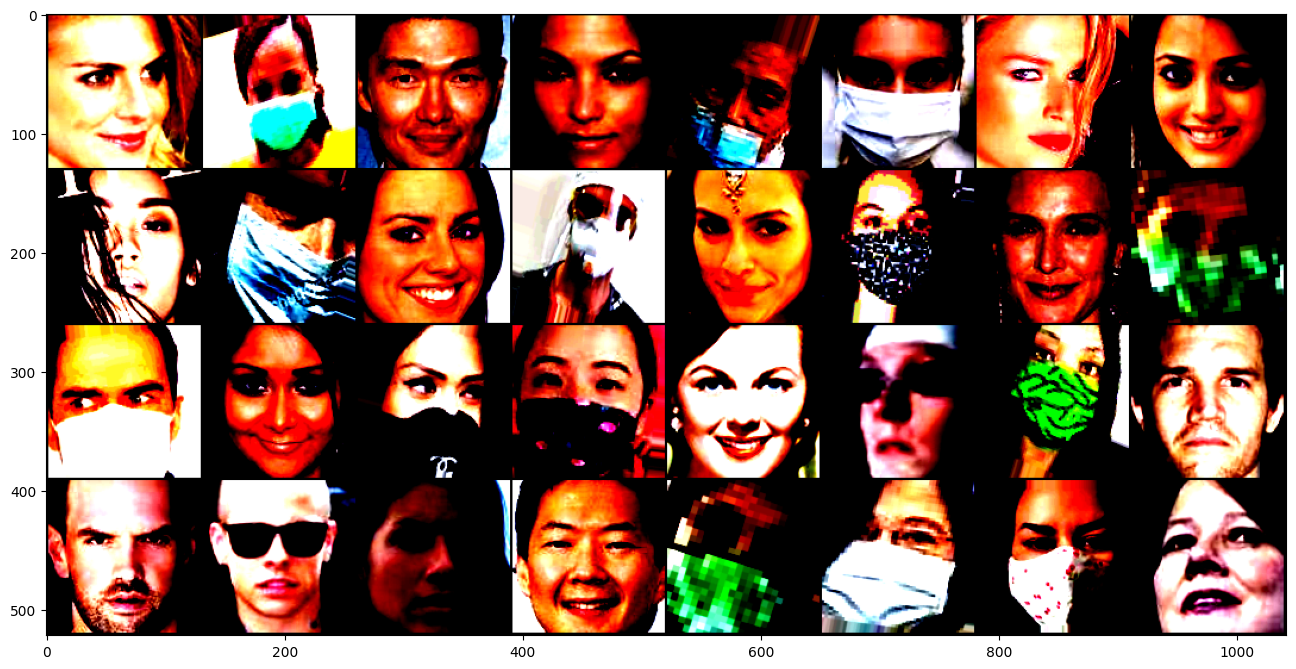

In [10]:
show_images(train_dl)

In [11]:
## checking the gpu if available
def device():
    if torch.cuda.is_available():
        print("cuda")
    else:
        print("cpu")
    

## load data into gpu or cpu
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DataDeviceLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
    
    def __len__(self):
        return len(self.dl)

In [12]:
device = device()
device

cpu


In [13]:
train_dl = DataDeviceLoader(train_dl, device)
val_dl = DataDeviceLoader(val_dl, device)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
## training function

def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class FaceMaskDetec(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, output):
        batch_loss = [x['val_loss'] for x in output]
        val_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in output]
        val_acc = torch.stack(batch_acc).mean()
        return {'val_loss': val_loss, 'val_acc': val_acc}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']
    ))


In [16]:
## CNN Model
#in_channels (int) – Number of channels in the input image
#out_channels (int) – Number of channels produced by the convolution
#kernel_size (int or tuple) – Size of the convolving kernel
#stride (int or tuple, optional) – Stride of the convolution. Default: 1
#padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0
#ReLU - Activation function returns 0 if the input is negative, but for any positive input.

class CNN(FaceMaskDetec):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),       # 16 x 64 x 64
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),       # 32 x 32 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),       # 64 x 16 x 16
            
            nn.MaxPool2d(4),       # 64 x 4 x 4
            nn.Flatten(),
            nn.Linear(64*4*4, 2)
        )

        
    def forward(self, input):
        out = self.network(input)
        out = F.sigmoid(out)
        return out

In [17]:
## loading the model into gpu or cpu

model = CNN()
model = to_device(model, device)
model

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Lin

In [18]:
## training and evaluating

@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(x) for x in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_dl, val_dl, weight_decay=0,
        grad_clip=None, opt_func=torch.optim.Adam):
    
    torch.cuda.empty_cache()
    history = []
    train_loss = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    lr_sch = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs=epochs,
                                                 steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lr_sch.step()
        
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_loss).mean()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
history = [evaluate(model, val_dl)]
history

C:\path\to\new\virtual\environment\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[{'val_loss': tensor(0.6941), 'val_acc': tensor(0.4330)}]

In [20]:
epochs = 3
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.05

In [21]:
%%time
history = fit(epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip)

Epoch [0], train_loss: 0.3934, val_loss: 0.3361, val_acc: 0.9766
Epoch [1], train_loss: 0.3685, val_loss: 0.3296, val_acc: 0.9844
Epoch [2], train_loss: 0.3556, val_loss: 0.3289, val_acc: 0.9810
CPU times: total: 27min 3s
Wall time: 3min 59s


In [22]:
## testing

def test(images, model):
    out = model(images)
    _, preds = torch.max(out, dim=1)
    return preds.item()

In [24]:
result_values = []
vv = 0
for x in test_dl:
    images, labels = x
    temp = test(images, model)
    result_values.append(temp)
    
print("The number of people wearing mask",result_values.count(0))
print("The number of people not wearing mask",result_values.count(1))
    

The number of people wearing mask 489
The number of people not wearing mask 503
